## 2 Layer MLP w/InfiMNIST

10,000 epochs of RMSProp

In [6]:
import tensorflow as tf
import numpy as np
import input_data

In [7]:
%run infimnist.py

In [8]:
num_epochs = 10000
batch_size = 125

learning_rate = 0.001

In [9]:
# Network Parameters
n_hidden_1 = 1000 # 1st layer num features
n_hidden_2 = 500 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

std_0 = 1.0/np.sqrt(n_input)
std_h1 = 1.0/np.sqrt(n_hidden_1)
std_h2 = 1.0/np.sqrt(n_hidden_2)

logfile = "2-layer-mlp-infimnist"

In [10]:
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

xt = tf.placeholder("float", [None, n_input])
yt = tf.placeholder("float", [None, n_classes])

In [11]:
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2'])) 
    return tf.matmul(layer_2, weights['out']) + biases['out']

In [12]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=std_0)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=std_h1)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=std_h2))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], stddev=0.1)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], stddev=0.01)),
    'out': tf.Variable(tf.random_normal([n_classes], stddev=0.001))
}

In [13]:
mlp = multilayer_perceptron(x, weights, biases )
mlp_test = multilayer_perceptron(xt, weights, biases )

In [14]:
cost =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mlp, y)) 
gs = tf.get_variable("global_step",[],trainable=False,initializer=tf.constant_initializer(0))
lr = tf.constant(learning_rate) 

In [15]:
train_op = tf.contrib.layers.optimize_loss(cost, global_step=gs, learning_rate=lr,optimizer="RMSProp")

In [16]:
#with tf.name_scope("training accuracy"):
pred = tf.equal(tf.argmax(mlp, 1), tf.argmax(y, 1)) # Count correct predictions
train_acc_op = tf.reduce_mean(tf.cast(pred, "float"))  # Cast boolean to float to average
tf.scalar_summary("training accuracy", train_acc_op)

<tf.Tensor 'ScalarSummary_2:0' shape=() dtype=string>

In [17]:
test_pred = tf.equal(tf.argmax(mlp_test, 1), tf.argmax(yt, 1)) # Count correct predictions
test_acc_op = tf.reduce_mean(tf.cast(test_pred, "float"))  # Cast boolean to float to average
tf.scalar_summary("test 0 accuracy", test_acc_op)

<tf.Tensor 'ScalarSummary_3:0' shape=() dtype=string>

In [18]:
infiminst = InfiMNIST()

In [19]:
!rm -rf ./logs/{logfile}
!ls logs

5-layer-mlp-infimnist


### Original MNIST Data

In [20]:
infiminst.next_epoch()
mnist = input_data.read_data_sets(".", one_hot=True)
trX_0, trY_0 = mnist.train.images, mnist.train.labels
teX_0, teY_0 = mnist.test.images, mnist.test.labels

//anaconda/lib/python2.7/gzip.py:275: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  chunk = self.extrabuf[offset: offset + size]
input_data.py:35: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


In [21]:
test_accuracies = []
train_accuracies = []
with tf.Session() as sess:
    # create a log writer. run 'tensorboard --logdir=./logs/{logfile}'
    writer = tf.train.SummaryWriter("./logs/{0}".format(logfile), sess.graph) # for 0.8
    merged = tf.merge_all_summaries()
 
    tf.initialize_all_variables().run()

    for epoch in range(num_epochs):
        infiminst.next_epoch()
        mnist = input_data.read_data_sets(".", one_hot=True)
    
        trX, trY = mnist.train.images, mnist.train.labels
        teX, teY = mnist.test.images, mnist.test.labels
        
        for start, end in zip(range(0, len(trX), batch_size), range(batch_size, len(trX), batch_size)):
            sess.run(train_op, feed_dict={x: trX[start:end], y: trY[start:end]})
                 
        summary, trn_acc, tst_acc = sess.run([merged, train_acc_op, test_acc_op], feed_dict={x: trX, y: trY, xt: teX_0, yt: teY_0})
        writer.add_summary(summary, epoch)  
        
        print(epoch, trn_acc, tst_acc)
        train_accuracies.append(trn_acc)
        test_accuracies.append(tst_acc)

        writer.flush()
        

(0, 0.92339998, 0.92989999)
(1, 0.96745455, 0.96520001)
(2, 0.97439998, 0.97210002)
(3, 0.97723639, 0.97189999)
(4, 0.98201817, 0.9774)
(5, 0.9842, 0.9795)
(6, 0.98619998, 0.97799999)
(7, 0.98629093, 0.98250002)
(8, 0.98649091, 0.98019999)
(9, 0.98496366, 0.97890002)
(10, 0.98941821, 0.98500001)
(11, 0.98767275, 0.98329997)
(12, 0.99012727, 0.98379999)
(13, 0.98809093, 0.9835)
(14, 0.98783636, 0.97939998)
(15, 0.98729092, 0.9806)
(16, 0.99316365, 0.98589998)
(17, 0.99101818, 0.98280001)
(18, 0.99178183, 0.98400003)
(19, 0.99192727, 0.98439997)
(20, 0.99143636, 0.98460001)
(21, 0.99274546, 0.98409998)
(22, 0.99285454, 0.98509997)
(23, 0.99103636, 0.9853)
(24, 0.99190909, 0.98769999)
(25, 0.99281818, 0.98460001)
(26, 0.99327272, 0.98439997)
(27, 0.99369091, 0.98479998)
(28, 0.99487275, 0.98640001)
(29, 0.99354547, 0.98509997)
(30, 0.99532729, 0.98580003)
(31, 0.99447274, 0.98689997)
(32, 0.99101818, 0.98290002)
(33, 0.99485457, 0.98720002)
(34, 0.99332726, 0.9867)
(35, 0.99532729, 0.9878

KeyboardInterrupt: 

In [29]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

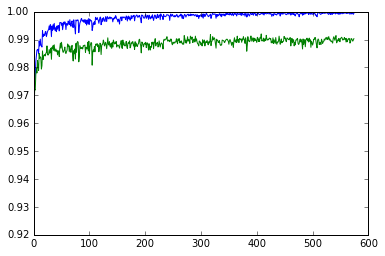

In [30]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)

In [31]:
plt.show()